In [1]:
## Jupyter notebook in python
## Produces postage stamp style plots of the identfied analogues, showing the circulation field (contours) and the hazard field (shading)

## Caveat: 

In [2]:
import analogue_functions_C3S as my

import xarray as xr
import os
import subprocess
import numpy as np
import iris
import calendar
import matplotlib.pyplot as plt
import matplotlib
cmaps = matplotlib.colormaps
import sys
import cartopy.crs as ccrs
import cartopy as cart
import cartopy.feature as cf
import netCDF4 as nc
import glob

from scipy.stats.stats import pearsonr
import scipy.stats as stats

/tmp/ipykernel_1155491/2326992444.py:19: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [3]:
# Defining the variables:
date = [2025, 'Apr', 5]         # as in 3.8A 
R1 = [50, 25, -70, -110] 
ana_var = 'z500' # 'msl' or 'z500'
haz_var = 'tp'



In [4]:
### Automated variables - can be adjusted for sensitivity testing

# months to include, automatically three calendar month window around the event
month = date[1]
X = list(calendar.month_abbr)
i=X.index(month)
if 1<i<12:
    months = [X[i-1], X[i], X[i+1]]
elif i == 1:
    months = [X[12], X[i], X[i+1]]
elif i ==12:
    months = [X[i-1], X[i], X[1]]

# Or use this line to manually select different month set (can be full year)
#months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# start and end of timeslices. Both timeslices should be same length for fair comparison
Y1 = 1950 # timeslice 1 start year
Y2 = 1980 # timeslice 1 end year
Y3 = 1994 # timeslice 2 start year
Y4 = 2024 # timeslice 2 end year

# number of analogues to use - set at 1% (assuming 30 day months) of timeslice 1 days 
N = int(((Y2-Y1)*len(months)*30)/100)
# Or use this line to manually select N, for plotting a multiple of 5, minus 1, ensures tidy figure
N = 19

In [5]:
# Check if using ERA5 or extended forecast (for when ERA5 not yet available)
event_data = 'era5'
# Initially using ERA5 daily data, if that gives no data switch to extended:
if my.reanalysis_data_single_date('t2m', date)==None:
    my.ERA5FILESUFFIX = "_daily_extended"
    event_data = "extended"
    print('ERA5 data not yet available, using ECMWF extended forecast for event data')

# If extended also not available give error message:
if my.reanalysis_data_single_date('t2m', date)==None:
    print('Data is not available for that date, please select a date between 1 Jan 1950 and the present day')
    quit() ## If the date has not data (ERA5 or extended) then stop here, and print message above

# Check what it is using:
my.ERA5FILESUFFIX

Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'Apr', 5]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc for date [2025, 'Apr', 5]


'_daily'

In [ ]:
dates_past = my.anomaly_period_outputs(Y1, Y2, ana_var, N, date, months, R1)
dates_prst = my.anomaly_period_outputs(Y3, Y4, ana_var, N, date, months, R1)

/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2025, 'Apr', 5]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/cube.py:3859: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/coords.py:2237: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'longitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/usr/pe

In [ ]:
def plot_specified_date(ax, date, title, ana_var, haz_var, R1): 
    circ = my.extract_region(my.reanalysis_data_single_date(ana_var, date), R1)
    #E = E - E.collapsed(['latitude', 'longitude'], iris.analysis.MEAN)
    haz = my.extract_region(my.reanalysis_data_single_date(haz_var, date), R1)
    lats=haz.coord('latitude').points
    lons=haz.coord('longitude').points
    if haz_var == 'tp':
        c = ax.contourf(lons, lats, haz.data, levels=np.linspace(1, 80, 9), cmap = plt.cm.get_cmap('Blues'), transform=ccrs.PlateCarree(), extend='max')
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
        fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
        cbar_ax.set_ylabel('Total Precipitation (mm)', labelpad=10, rotation=270, fontsize=12)
        cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])
    elif haz_var == 't2m':
        c = ax.contourf(lons, lats, haz.data-273.15, levels=np.linspace(np.min(haz.data-273.15), np.max(haz.data-273.15), 9), cmap = plt.cm.get_cmap('RdBu_r'), transform=ccrs.PlateCarree(), extend='max')
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.4])
        fig.colorbar(c, cax=cbar_ax, ticks=np.arange(np.min(haz.data-273.15), np.max(haz.data-273.15), 5))
        cbar_ax.set_ylabel('t2m', labelpad=10, rotation=270, fontsize=12)
        #cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])
    lats=circ.coord('latitude').points
    lons=circ.coord('longitude').points
    c2 = axs.contour(lons, lats, circ.data/100, colors='k', transform=ccrs.PlateCarree(), extend='both')
    axs.clabel(c2, inline=1, fontsize=12)
    axs.add_feature(cf.BORDERS)
    axs.add_feature(cf.COASTLINE)
    axs.set_title(title, loc='left')

In [ ]:
# Past date fields
circ_past = iris.cube.CubeList([])
haz_past = iris.cube.CubeList([])

n = len(dates_past)
for each in range(n):
    year = int(dates_past[each][:4])
    month = calendar.month_abbr[int(dates_past[each][4:-2])]
    day = int(dates_past[each][-2:])
    circ_past.append(my.extract_region(my.reanalysis_data_single_date(ana_var, [year, month, day]), R1))
    haz_past.append(my.extract_region(my.reanalysis_data_single_date(haz_var, [year, month, day]), R1))

Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1968, 'Mar', 21]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1968, 'Mar', 21]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1973, 'Mar', 15]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1973, 'Mar', 15]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1957, 'May', 23]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1957, 'May', 23]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1964, 'Mar', 3]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1964, 'Mar', 3]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1953, 'May', 15]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1953, 'May', 15]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1952, 'Mar', 10]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1952, 'Mar', 10]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1972, 'Apr', 15]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1972, 'Apr', 15]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1975, 'Mar', 12]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1975, 'Mar', 12]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1959, 'Apr', 18]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1959, 'Apr', 18]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1973, 'Mar', 8]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1973, 'Mar', 8]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1951, 'Mar', 28]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1951, 'Mar', 28]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1958, 'May', 3]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1958, 'May', 3]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1979, 'Mar', 30]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1979, 'Mar', 30]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1968, 'Mar', 11]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1968, 'Mar', 11]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1966, 'Apr', 24]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1966, 'Apr', 24]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1959, 'Apr', 9]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1959, 'Apr', 9]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1978, 'Mar', 13]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1978, 'Mar', 13]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1964, 'Mar', 9]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1964, 'Mar', 9]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1952, 'Mar', 3]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1952, 'Mar', 3]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2025, 'Apr', 5]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2025, 'Apr', 5]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/but

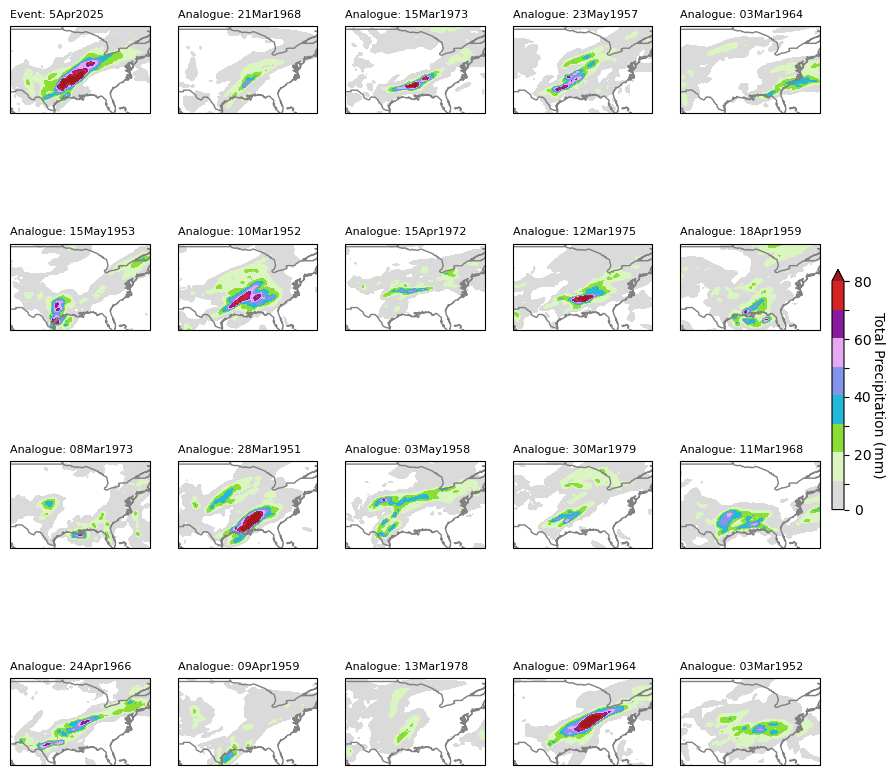

In [ ]:
## OPTIONS ##
# How many analogues?
n = 19 # no more than 29
# With circulation?
circ_plot = 0 # 1: plots circulation contours, 0: does not

import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

cpt = pd.read_csv('/usr/people/thompson/WP1/wetVdry/paper_figs/colormapGeert.txt',sep=' ',index_col=False) #.to_xarray()
colorsGL = [(cpt['R1'][i]/255,cpt['G1'][i]/255,cpt['B1'][i]/255) for i,v in enumerate(cpt['R1'])]
levelsGL = cpt['val1'].astype('int')
cmap_name = 'my_list'
my_cmap = LinearSegmentedColormap.from_list(cmap_name, colorsGL, N=24)

# Past dates plot
lats=circ_past[0].coord('latitude').points
lons=circ_past[0].coord('longitude').points
fig, axs = plt.subplots(nrows=(int(np.ceil((n+1)/5))), ncols=5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,12))

circ = my.extract_region(my.reanalysis_data_single_date(ana_var, date), R1)
haz = my.extract_region(my.reanalysis_data_single_date(haz_var, date), R1)

if haz_var == 'tp':
    c = axs[0,0].contourf(lons, lats, haz.data, levels=np.linspace(1, 80, 9), cmap = my_cmap, transform=ccrs.PlateCarree(), extend='max')
    fig.subplots_adjust(right=0.8, hspace=-.2)
    cbar_ax = fig.add_axes([0.81, 0.4, 0.01, 0.2])
    fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
    cbar_ax.set_ylabel('Total Precipitation (mm)', labelpad=10, rotation=270, fontsize=10)
    cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])
elif haz_var == 't2m':
    c = axs[0,0].contourf(lons, lats, haz.data-273.15, levels=np.linspace(np.min(haz.data-273.15), np.max(haz.data-273.15), 9), cmap = plt.cm.get_cmap('RdBu_r'), transform=ccrs.PlateCarree(), extend='max')
    

if circ_plot == 1: c2 = axs[0,0].contour(lons, lats, circ.data/100, colors='k', transform=ccrs.PlateCarree(), extend='both')
axs[0,0].clabel(c2, inline=1, fontsize=12)
axs[0,0].add_feature(cf.BORDERS, color='grey')
axs[0,0].add_feature(cf.COASTLINE, color='grey')
axs[0,0].set_title('Event: '+str(date[2])+date[1]+str(date[0]), loc='left', fontsize=8)


for i, ax in enumerate(np.ravel(axs)[1:n+1]):
    if haz_var == 'tp':
        c = ax.contourf(lons, lats, haz_past[i].data, levels=np.linspace(1, 80, 9), cmap = my_cmap, transform=ccrs.PlateCarree(), extend='max')
    elif haz_var == 't2m':
        c = ax.contourf(lons, lats, haz_past[i].data-273.15, levels=np.linspace(np.min(haz_past[i].data-273.15), np.max(haz_past[i].data-273.15), 9), cmap = plt.cm.get_cmap('RdBu_r'), transform=ccrs.PlateCarree(), extend='max')
    if circ_plot == 1: c2 = ax.contour(lons, lats, circ_past[i].data/100, colors='k', transform=ccrs.PlateCarree(), extend='both')
    ax.clabel(c2, inline=1, fontsize=12)
    ax.add_feature(cf.BORDERS, color='grey')
    ax.add_feature(cf.COASTLINE, color='grey')
    ax.set_title('Analogue: '+str(dates_past[i][-2:])+calendar.month_abbr[int(dates_past[i][4:-2])]+str(dates_past[i][:4]), loc='left', fontsize=8)


In [ ]:
# Prst date fields
circ_prst = iris.cube.CubeList([])
haz_prst = iris.cube.CubeList([])

n = len(dates_prst)
for each in range(n):
    year = int(dates_prst[each][:4])
    month = calendar.month_abbr[int(dates_prst[each][4:-2])]
    day = int(dates_prst[each][-2:])
    circ_prst.append(my.extract_region(my.reanalysis_data_single_date(ana_var, [year, month, day]), R1))
    haz_prst.append(my.extract_region(my.reanalysis_data_single_date(haz_var, [year, month, day]), R1))

Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2019, 'Apr', 13]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2019, 'Apr', 13]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2000, 'Apr', 2]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2000, 'Apr', 2]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2008, 'Mar', 3]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2008, 'Mar', 3]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2018, 'Mar', 28]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2018, 'Mar', 28]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2017, 'Apr', 29]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2017, 'Apr', 29]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1995, 'Apr', 19]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1995, 'Apr', 19]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2016, 'Mar', 9]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2016, 'Mar', 9]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2020, 'Mar', 19]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2020, 'Mar', 19]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1994, 'Apr', 29]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1994, 'Apr', 29]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2021, 'Mar', 25]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2021, 'Mar', 25]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2016, 'Mar', 31]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2016, 'Mar', 31]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2008, 'Mar', 18]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2008, 'Mar', 18]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2004, 'Mar', 4]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2004, 'Mar', 4]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2011, 'May', 2]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2011, 'May', 2]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2012, 'Apr', 16]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2012, 'Apr', 16]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2010, 'May', 14]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2010, 'May', 14]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2019, 'May', 10]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2019, 'May', 10]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1998, 'Mar', 30]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1998, 'Mar', 30]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [1996, 'Apr', 22]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [1996, 'Apr', 22]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)


Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_z500_daily.nc for date [2025, 'Apr', 5]
Read file: /net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tp_daily.nc for date [2025, 'Apr', 5]


/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/iris/fileformats/_nc_load_rules/helpers.py:862: UserWarning: Ignoring netCDF variable 'tp' invalid units 'mm/dy'
  warnings.warn(msg)
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/butterfly/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/usr/people/thompson/anaconda3/envs/but

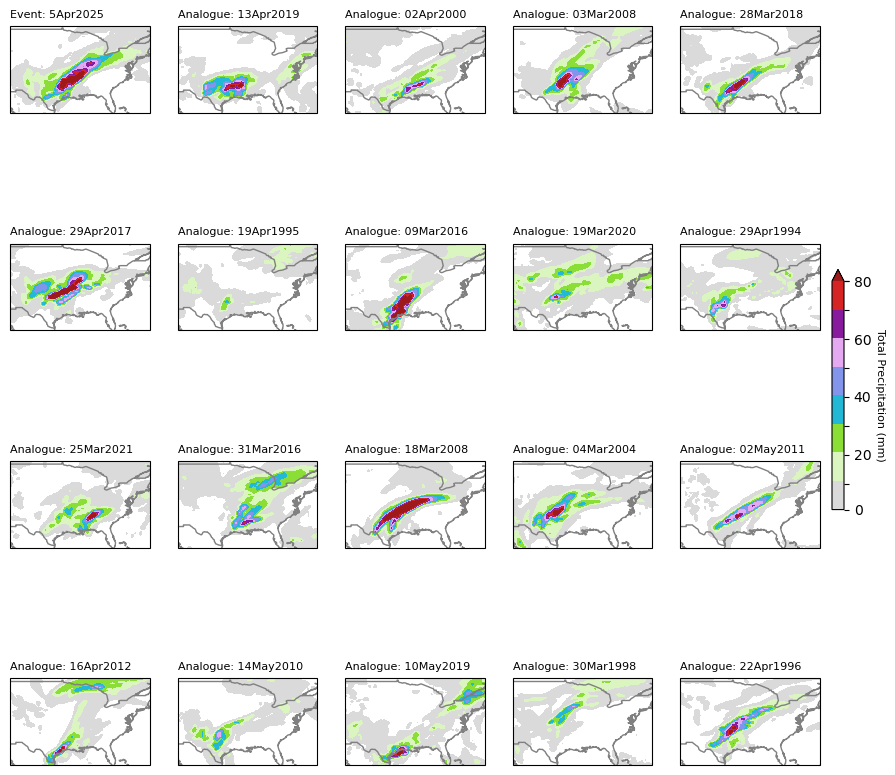

In [ ]:
# Past dates plot
lats=circ_prst[0].coord('latitude').points
lons=circ_prst[0].coord('longitude').points
fig, axs = plt.subplots(nrows=(int(np.ceil((n+1)/5))), ncols=5, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,12))

circ = my.extract_region(my.reanalysis_data_single_date(ana_var, date), R1)
haz = my.extract_region(my.reanalysis_data_single_date(haz_var, date), R1)

if haz_var == 'tp':
    c = axs[0,0].contourf(lons, lats, haz.data, levels=np.linspace(1, 80, 9), cmap = my_cmap, transform=ccrs.PlateCarree(), extend='max')
    fig.subplots_adjust(right=0.8, hspace=-0.2)
    cbar_ax = fig.add_axes([0.81, 0.4, 0.01, 0.2])
    fig.colorbar(c, cax=cbar_ax, ticks=np.arange(0, 100, 10))
    cbar_ax.set_ylabel('Total Precipitation (mm)', labelpad=10, rotation=270, fontsize=8)
    cbar_ax.set_yticklabels(['0', '', '20','','40','','60','','80',''])
elif haz_var == 't2m':
    c = axs[0,0].contourf(lons, lats, haz.data-273.15, levels=np.linspace(np.min(haz.data-273.15), np.max(haz.data-273.15), 9), cmap = plt.cm.get_cmap('RdBu_r'), transform=ccrs.PlateCarree(), extend='max')
    

if circ_plot == 1: c2 = axs[0,0].contour(lons, lats, circ.data/100, colors='k', transform=ccrs.PlateCarree(), extend='both')
axs[0,0].clabel(c2, inline=1, fontsize=12)
axs[0,0].add_feature(cf.BORDERS, color='grey')
axs[0,0].add_feature(cf.COASTLINE, color='grey')
axs[0,0].set_title('Event: '+str(date[2])+date[1]+str(date[0]), loc='left', fontsize=8)


for i, ax in enumerate(np.ravel(axs)[1:n+1]):
    if haz_var == 'tp':
        c = ax.contourf(lons, lats, haz_prst[i].data, levels=np.linspace(1, 80, 9), cmap = my_cmap, transform=ccrs.PlateCarree(), extend='max')
    elif haz_var == 't2m':
        c = ax.contourf(lons, lats, haz_prst[i].data-273.15, levels=np.linspace(np.min(haz_prst[i].data-273.15), np.max(haz_prst[i].data-273.15), 9), cmap = plt.cm.get_cmap('RdBu_r'), transform=ccrs.PlateCarree(), extend='max')
    if circ_plot == 1: c2 = ax.contour(lons, lats, circ_prst[i].data/100, colors='k', transform=ccrs.PlateCarree(), extend='both')
    ax.clabel(c2, inline=1, fontsize=12)
    ax.add_feature(cf.BORDERS, color='grey')
    ax.add_feature(cf.COASTLINE, color='grey')
    ax.set_title('Analogue: '+str(dates_prst[i][-2:])+calendar.month_abbr[int(dates_prst[i][4:-2])]+str(dates_prst[i][:4]), loc='left', fontsize=8)
